# 1. Import Statements

### 1.1 Installing Required Libraries

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras-preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.2 Importing Required Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import re 
import random
import string      # for string operations 

import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from gensim.models import Word2Vec
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout, Bidirectional, Input
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike

# LSTM components
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

# CRF layer
from tensorflow_addons.layers import CRF

# Sigmoid focal cross entropy loss. works well with highly unbalanced input data
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.optimizers import Adam

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Plots
import matplotlib.pyplot as plt

# Spacy specific libraries 
import spacy
import contractions

# Import label encoder
from sklearn import preprocessing
# Track progress 
from tqdm.notebook import tqdm

from keras.utils import to_categorical
# Import NLTK for BERT tokenization data processing 
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 1.3 Hyperparameters , Configurations 

In [ ]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector

# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

# Train , test file 
train_data_file_location = 'wnut 16.txt.conll'
test_data_file_location = 'wnut 16test.txt.conll'
merged_file_location = 'merged_file.conll'

# 2. Download the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!gdown 1leDYnaExeLhelTWuJTROvO6pYvvllisV

Downloading...
From: https://drive.google.com/uc?id=1leDYnaExeLhelTWuJTROvO6pYvvllisV
To: /content/wnut 16.txt.conll
100% 403k/403k [00:00<00:00, 84.1MB/s]


In [ ]:
!gdown 1vVckmDcRHdfeCp5RLLRMu7EoJbZcMmMf

Downloading...
From: https://drive.google.com/uc?id=1vVckmDcRHdfeCp5RLLRMu7EoJbZcMmMf
To: /content/wnut 16test.txt.conll
100% 635k/635k [00:00<00:00, 91.1MB/s]


# 3. Problem Statement
- **Recognizing important content of the tweets** even without followings:
  - Dependency on Hashtags
  - Overcome problems of mis-spelled tags
- **Extracting core contexual information** that seeks to locate and recognise named entities
- **Train models** that will be able **to identify the various named entities**
- **Create & compare** at different models


# 4. Read & Explore Data

## 4.1 Merge Train and Test Data

In [ ]:
def merge_conll_files(file1, file2, merged_file):
    with open(file1, 'r', encoding='utf-8') as f1, open(file2, 'r', encoding='utf-8') as f2, open(merged_file, 'w', encoding='utf-8') as output:
        output.writelines(f1.readlines())
        output.writelines('\n')  # Add an empty line between the two files
        output.writelines(f2.readlines())

merge_conll_files(train_data_file_location, test_data_file_location, merged_file_location)

## 4.2 Read CoNLL Formatted Data

In [ ]:
def conll_to_dataframe(conll_file):
    sentences = []
    sentence_nums = []
    words = []
    tags = []
    with open(conll_file, 'r', encoding='utf-8') as file:
        sentence_num = 1
        for line in file:
            line = line.strip()
            if line:
                fields = line.split('\t')
                sentence_nums.append("Sentence: "+str(sentence_num))
                words.append(fields[0])
                tags.append(fields[1])
            else:
                sentence_num += 1
    
    # Convert to DataFrame
    df = pd.DataFrame({'Sentence #': sentence_nums, 'Word': words, 'Tag': tags})
    return df

# Read Data 
data = conll_to_dataframe(merged_file_location)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108377 entries, 0 to 108376
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Sentence #  108377 non-null  object
 1   Word        108377 non-null  object
 2   Tag         108377 non-null  object
dtypes: object(3)
memory usage: 2.5+ MB


In [ ]:
data[data["Sentence #"] == "Sentence: 1"]

,Sentence #,Word,Tag
0,Sentence: 1,@SammieLynnsMom,O
1,Sentence: 1,@tg10781,O
2,Sentence: 1,they,O
3,Sentence: 1,will,O
4,Sentence: 1,be,O
5,Sentence: 1,all,O
6,Sentence: 1,done,O
7,Sentence: 1,by,O
8,Sentence: 1,Sunday,O
9,Sentence: 1,trust,O


In [ ]:
df_bert = data.copy()
df_bert.head()

,Sentence #,Word,Tag
0,Sentence: 1,@SammieLynnsMom,O
1,Sentence: 1,@tg10781,O
2,Sentence: 1,they,O
3,Sentence: 1,will,O
4,Sentence: 1,be,O


In [ ]:
agg_words_to_sentence = lambda s: [(w,t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]

In [ ]:
sentences = data.groupby("Sentence #").apply(agg_words_to_sentence)
sentences

Sentence #
Sentence: 1       [(@SammieLynnsMom, O), (@tg10781, O), (they, O...
Sentence: 10      [(@daraobriain, O), (hmmm, O), (., O), (Cant, ...
Sentence: 100     [('Was, O), (going, O), (to, O), (stay, O), (u...
Sentence: 1000    [(RT, O), (@TMZ, O), (:, O), (Lindsay, B-perso...
Sentence: 1001    [(Pope, B-person), (says, O), (religion, O), (...
                                        ...                        
Sentence: 995     [(I, O), (am, O), (living, O), (my, O), (dream...
Sentence: 996     [(Good, O), (day, O), (today, O), (:), O), (),...
Sentence: 997     [(On, O), (the, O), (bus, O), (., O), (Full, O...
Sentence: 998     [(Today, O), ('s, O), (post, O), (is, O), (abo...
Sentence: 999     [(omg, O), (@wethekings, O), (is, O), (playing...
Length: 6244, dtype: object

In [ ]:
data["Sentence #"].value_counts()[data["Sentence #"].unique()]

Sentence: 1       12
Sentence: 2       33
Sentence: 3       11
Sentence: 4       27
Sentence: 5        6
                  ..
Sentence: 6240    23
Sentence: 6241    14
Sentence: 6242    16
Sentence: 6243    27
Sentence: 6244    12
Name: Sentence #, Length: 6244, dtype: int64

 ### 4.1.1 Data Shape

In [ ]:
data.shape

(108377, 3)

### 4.1.2 Data Types

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108377 entries, 0 to 108376
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Sentence #  108377 non-null  object
 1   Word        108377 non-null  object
 2   Tag         108377 non-null  object
dtypes: object(3)
memory usage: 2.5+ MB


## 4.2 Explore Data

 ### 4.2.1 Exploring Sentences

In [ ]:
print("Number of sentences: ", len(data.groupby(['Sentence #'])))

Number of sentences:  6244


 ### 4.2.2 Exploring Words/Tokens

In [ ]:
words = list(set(data["Word"].values))
n_words = len(words)
print("Number of unique words in the dataset: ", n_words)

Number of unique words in the dataset:  25383


 ### 4.2.3 Exploring Unique Tags

In [ ]:
n_tags = len(data.groupby(['Tag']))
print("Number of Labels: ", n_tags)

Number of Labels:  21


In [ ]:
data["Tag"].value_counts()

O                99960
B-geo-loc         1158
B-person           931
I-other            876
B-other            809
B-company          792
I-product          580
I-person           515
I-facility         471
B-facility         357
B-product          343
I-company          301
I-geo-loc          268
B-musicartist      246
I-musicartist      201
B-sportsteam       198
I-movie             94
I-sportsteam        71
I-tvshow            71
B-movie             68
B-tvshow            67
Name: Tag, dtype: int64

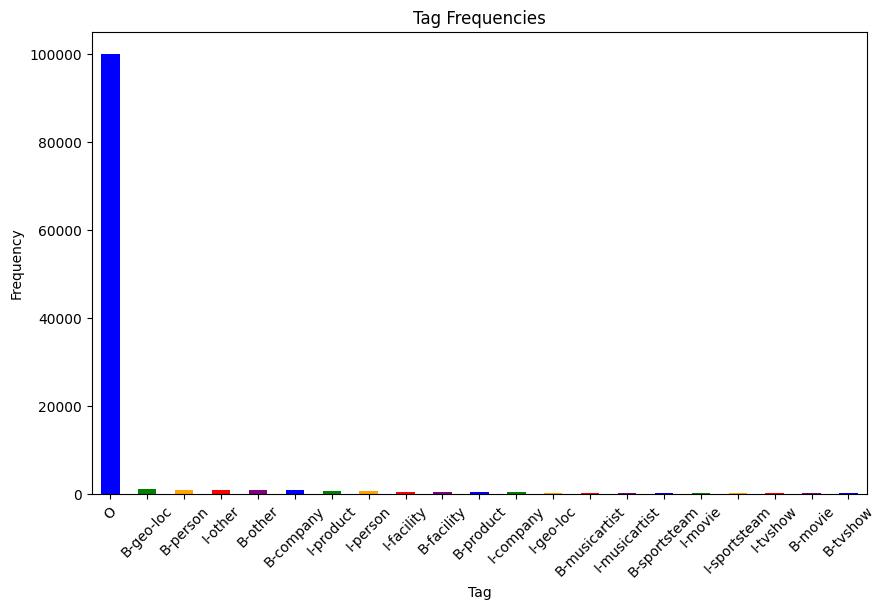

In [ ]:
def plot_tag_frequencies(data):
    # Calculate tag frequencies
    tag_counts = data['Tag'].value_counts()

    # Define custom colors for the tags
    colors = ['blue', 'green', 'orange', 'red', 'purple']  # Add more colors if needed
    
    # Plot the tag frequencies as a bar plot
    plt.figure(figsize=(10, 6))
    tag_counts.plot(kind='bar',color=colors)
    plt.xlabel('Tag')
    plt.ylabel('Frequency')
    plt.title('Tag Frequencies')
    plt.xticks(rotation=45)
    plt.show()

plot_tag_frequencies(data)

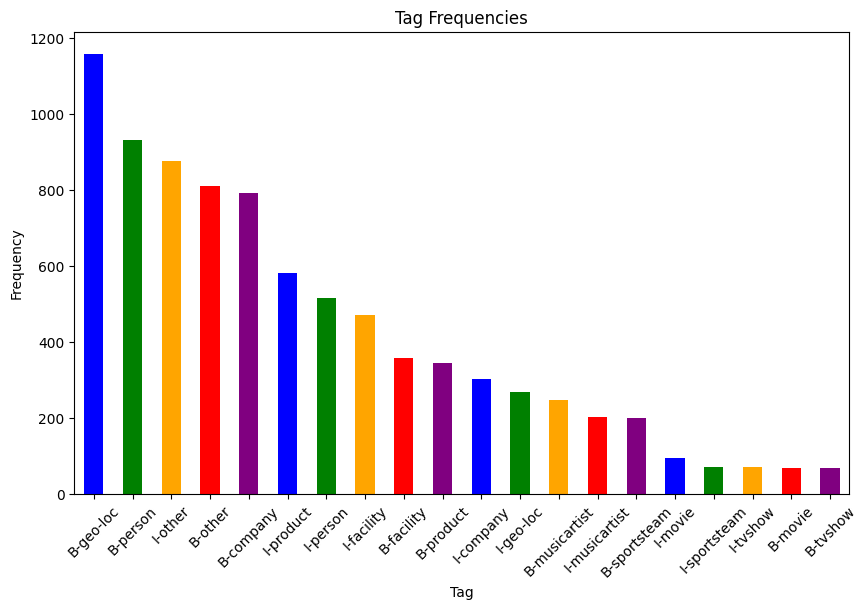

In [ ]:
df_exluding_others = data[data["Tag"] != "O"]
plot_tag_frequencies(df_exluding_others)

# 5. Processing the Text Data
- Preparing the data in the format required by models

## 5.1 Pre-processing - Part I (Basic)


### 5.1.1 Cleaning tags of **other category**

In [ ]:
print("Shape before removing other tags ",data.shape)
data = data[data["Tag"] != "O"]
print("Shape after removing other tags ",data.shape)

Shape before removing other tags  (108377, 3)
Shape after removing other tags  (8417, 3)


### 5.1.2 Cleaning words -  Lower case , Special chars , Punctuation etc.
- Converting to Lower case 
- Remove punctuation (i.e. non-letters)


In [ ]:
def process_sentence(sentence, nlp_object):
    # Convert to lowercase
    sentence = sentence.lower()
    
    # Exapnding contractions
    #sentence = contractions.fix(sentence)
    
    # Lemmatization and removing stopwords
    #doc = nlp_object(sentence)
    #sentence = " ".join([token.lemma_ for token in doc if not token.is_stop])

    # Remove Special characters - Hashtags , @ 
    sentence = re.sub("[^A-Z]", "", sentence,0,re.IGNORECASE)
    
    # Remove punctuation
    for p in string.punctuation:
        sentence = sentence.replace(p, " ")
    sentence = re.sub(r"\s+", " ", sentence) # Replace all whitespace characters with space
    
    return sentence

In [ ]:
tqdm.pandas()
nlp = spacy.load('en_core_web_sm') # English pipeline optimized for CPU
data["Word_processed"] = data["Word"].progress_apply(lambda x : process_sentence(x, nlp))

  0%|          | 0/8417 [00:00<?, ?it/s]

In [ ]:
data.head()

,Sentence #,Word,Tag,Word_processed
17,Sentence: 2,GA,B-geo-loc,ga
25,Sentence: 2,Disney,B-facility,disney
26,Sentence: 2,world,I-facility,world
41,Sentence: 2,Disney,B-facility,disney
42,Sentence: 2,World,I-facility,world


In [ ]:
sentences = data.groupby("Sentence #").apply(agg_words_to_sentence)
sentences

Sentence #
Sentence: 10              [(the, B-facility), (Apollo, I-facility)]
Sentence: 100                                   [(Kent, B-geo-loc)]
Sentence: 1000    [(Lindsay, B-person), (Lohan, I-person), (TMZ,...
Sentence: 1001                                   [(Pope, B-person)]
Sentence: 1004          [(windows, B-product), (office, B-product)]
                                        ...                        
Sentence: 987     [(spencer, B-person), (iCarly, B-tvshow), (Cra...
Sentence: 988     [(TEACHER'S, B-other), (DAY, I-other), (2, I-o...
Sentence: 989                              [(Cyber-Ark, B-company)]
Sentence: 993                                [(YouTube, B-company)]
Sentence: 999                               [(Stetson, B-facility)]
Length: 2932, dtype: object

In [ ]:
data[["Sentence #","Word_processed","Word"]].head(100)

,Sentence #,Word_processed,Word
17,Sentence: 2,ga,GA
25,Sentence: 2,disney,Disney
26,Sentence: 2,world,world
41,Sentence: 2,disney,Disney
42,Sentence: 2,world,World
...,...,...,...
1607,Sentence: 86,pepsi,Pepsi
1616,Sentence: 86,nokia,Nokia
1617,Sentence: 86,,5800
1646,Sentence: 88,dems,Dems


In [ ]:
# Calculate the missing value percentage
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Sort the missing value percentage in descending order
sorted_percentage = missing_percentage.sort_values(ascending=False)

# Print the sorted percentage
print(sorted_percentage)

Sentence #        0.0
Word              0.0
Tag               0.0
Word_processed    0.0
dtype: float64


In [ ]:
missing_data = data[data.isnull().any(axis=1)]
missing_data

,Sentence #,Word,Tag,Word_processed


### 5.1.3 Creating parts of speech feature (POS)

In [ ]:
# Function to perform POS tagging on a given text
def pos_tagging(word):
    doc = nlp(word)  # Process the text with spaCy
    # Check if the document has any tokens
    if len(doc) > 0:
      # Extract POS tag for the word
      #pos_tag = doc[0].pos_
      pos_tag = doc[0].tag_
    else:
      pos_tag = "Unknown"

    return pos_tag

# Apply POS tagging on the 'Text' column
# print(f'{token.text:{8}} {token.pos_:{6}} {token.tag_:{6}} {token.dep_:{6}} {spacy.explain(token.pos_):{20}} {spacy.explain(token.tag_)}')

data['POS_Tags'] = data['Word_processed'].progress_apply(pos_tagging)

  0%|          | 0/8417 [00:00<?, ?it/s]

In [ ]:
data.head()

,Sentence #,Word,Tag,Word_processed,POS_Tags
17,Sentence: 2,GA,B-geo-loc,ga,VB
25,Sentence: 2,Disney,B-facility,disney,NN
26,Sentence: 2,world,I-facility,world,NN
41,Sentence: 2,Disney,B-facility,disney,NN
42,Sentence: 2,World,I-facility,world,NN


## 5.2 Pre-processing - Part II
For Preprocessing, we will first put each sentence through a function which will put each of the words along with its POS and Tag together in a tuple. Each sentence will form a list of tuples.

In [ ]:
data = data[["Sentence #","Word_processed","POS_Tags","Tag"]]
data.rename(columns={"Word_processed":"Word","POS_Tags":"POS","Tag":"Label"}, inplace = True)
data.head()

<ipython-input-255-29e4041ef985>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={"Word_processed":"Word","POS_Tags":"POS","Tag":"Label"}, inplace = True)


,Sentence #,Word,POS,Label
17,Sentence: 2,ga,VB,B-geo-loc
25,Sentence: 2,disney,NN,B-facility
26,Sentence: 2,world,NN,I-facility
41,Sentence: 2,disney,NN,B-facility
42,Sentence: 2,world,NN,I-facility


In [ ]:
agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Label"].values.tolist())]

In [ ]:
grouped = data.groupby("Sentence #").apply(agg_func)
grouped

Sentence #
Sentence: 10      [(the, DT, B-facility), (apollo, NNP, I-facili...
Sentence: 100                               [(kent, VB, B-geo-loc)]
Sentence: 1000    [(lindsay, VB, B-person), (lohan, NNP, I-perso...
Sentence: 1001                               [(pope, NN, B-person)]
Sentence: 1004    [(windows, NNS, B-product), (office, NN, B-pro...
                                        ...                        
Sentence: 987     [(spencer, NN, B-person), (icarly, RB, B-tvsho...
Sentence: 988     [(teachers, NNS, B-other), (day, NN, I-other),...
Sentence: 989                           [(cyberark, NN, B-company)]
Sentence: 993                            [(youtube, VB, B-company)]
Sentence: 999                          [(stetson, NNP, B-facility)]
Length: 2932, dtype: object

In [ ]:
sentences = [s for s in grouped]
sentences

[[('the', 'DT', 'B-facility'), ('apollo', 'NNP', 'I-facility')],
 [('kent', 'VB', 'B-geo-loc')],
 [('lindsay', 'VB', 'B-person'),
  ('lohan', 'NNP', 'I-person'),
  ('tmz', 'NN', 'B-company')],
 [('pope', 'NN', 'B-person')],
 [('windows', 'NNS', 'B-product'), ('office', 'NN', 'B-product')],
 [('constitution', 'NN', 'B-other'), ('day', 'NN', 'I-other')],
 [('port', 'NN', 'B-company'),
  ('city', 'NN', 'I-company'),
  ('java', 'RB', 'I-company')],
 [('phil', 'NNP', 'B-geo-loc'),
  ('society', 'NN', 'B-other'),
  ('of', 'IN', 'I-other'),
  ('mining', 'NN', 'I-other'),
  ('and', 'CC', 'I-other'),
  ('metallurgy', 'NNP', 'I-other'),
  ('engineers', 'NNS', 'I-other')],
 [('white', 'NNP', 'B-facility'), ('eagle', 'VB', 'I-facility')],
 [('japan', 'NNP', 'B-geo-loc')],
 [('brandy', 'NN', 'B-person')],
 [('fight', 'VB', 'B-facility'),
  ('club', 'NN', 'I-facility'),
  ('chicago', 'NNP', 'B-geo-loc'),
  ('pringles', 'NNS', 'B-product')],
 [('pete', 'JJ', 'B-person')],
 [('justin', 'JJ', 'B-person

In [ ]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_n, Tag_n)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.sentence_list =  data["Sentence #"].unique()
        self.n_sent = 0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Label"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            #s = self.grouped["Sentence: {}".format(self.n_sent)]
            s = self.grouped[self.sentence_list[self.n_sent]]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('ga', 'VB', 'B-geo-loc'), ('disney', 'NN', 'B-facility'), ('world', 'NN', 'I-facility'), ('disney', 'NN', 'B-facility'), ('world', 'NN', 'I-facility')]


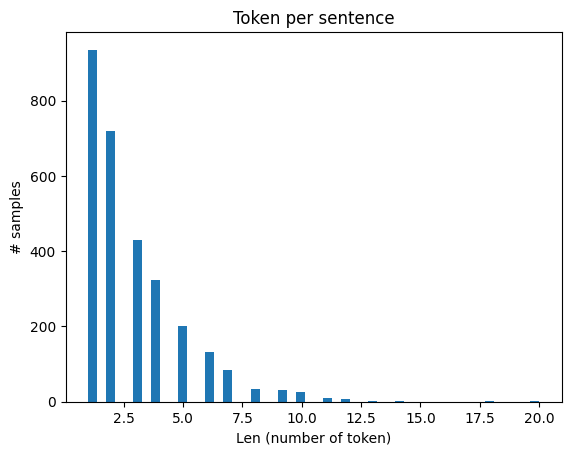

In [ ]:
# Get all the sentences
sentences = getter.sentences
# Plot sentence by length
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

## 5.3 Pre-processing - Word 2 Index  
- We will convert each text word to a corresponding integer ID using the <b> word2idx dictionary</b>. Doing so saves a lot of memory.
- In order to feed the data to our Bi-LSTM-CRF model, we need to ensure that all text should be of the same length. 
 - The method sequence.pad_sequences() and variable MAX_LEN are used for this purpose.
 - The text which are shorter than MAX_LEN are padded to get them to the same length, whereas text which are longer than MAX_LEN are truncated.


In [ ]:
data["Label"].unique()

array(['B-geo-loc', 'B-facility', 'I-facility', 'B-movie', 'I-movie',
       'B-company', 'B-product', 'B-person', 'B-other', 'I-other',
       'B-sportsteam', 'I-sportsteam', 'I-product', 'I-company',
       'I-person', 'I-geo-loc', 'B-tvshow', 'B-musicartist',
       'I-musicartist', 'I-tvshow'], dtype=object)

In [ ]:
g = data.groupby(['Label'])
g.groups.keys()

dict_keys(['B-company', 'B-facility', 'B-geo-loc', 'B-movie', 'B-musicartist', 'B-other', 'B-person', 'B-product', 'B-sportsteam', 'B-tvshow', 'I-company', 'I-facility', 'I-geo-loc', 'I-movie', 'I-musicartist', 'I-other', 'I-person', 'I-product', 'I-sportsteam', 'I-tvshow'])

In [ ]:
missing_data = data[data.isnull().any(axis=1)]
missing_data

,Sentence #,Word,POS,Label


In [ ]:
class NERPreprocessor:
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm')
        self.word2index = {}
        self.label2index = {}
        self.index2label = {}

    def fit(self, data):
        words = data["Word"].values
        pos_tags = data["POS"].values
        labels = data["Label"].values

        # Create word-to-index mapping
        # Vocabulary Key:word -> Value:token_index
        unique_words = np.unique(words)
        # The first 2 entries are reserved for PAD and UNK
        self.word2index = {word: index + 2 for index, word in enumerate(unique_words)}
        self.word2index["UNK"] = 1 # Unknown words
        self.word2index["PAD"] = 0 # Padding

        # Create label-to-index mapping
        # Vocabulary Key:Label/Tag -> Value:tag_index
        unique_labels = np.unique(labels)
        # The first entry is reserved for PAD
        self.label2index = {label: index+1 for index, label in enumerate(unique_labels)}
        self.label2index["PAD"] = 0 # Padding

        # Vocabulary Key:tag_index -> Value:Label/Tag
        self.index2label["PAD"] =  {index: label for label, index in self.label2index.items()}

    def preprocess(self, data):
        # Convert each sentence from list of Token to list of word_index
        word_indices = [[self.word2index[w[0]] for w in s] for s in sentences]

        # Padding each sentence to have the same lenght
        word_indices = pad_sequences(maxlen=MAX_LEN, sequences=word_indices, padding="post", value=self.word2index["PAD"])

        # Convert Tag/Label to tag_index
        label_indices = [[self.label2index[w[2]] for w in s] for s in sentences]

        # Padding each sentence to have the same lenght
        label_indices = pad_sequences(maxlen=MAX_LEN, sequences=label_indices, padding="post", value=self.label2index["PAD"])

        # One-Hot encode
        #number_labels = data["Label"].nunique()
        number_labels = n_tags
        label_indices = [to_categorical(i, num_classes=number_labels) for i in label_indices]  # number_labels(as PAD has been already added in constructor)

        return word_indices,label_indices

In [ ]:
preprocessor = NERPreprocessor()
preprocessor.fit(data)

In [ ]:
word_indices, label_indices = preprocessor.preprocess(data)

In [ ]:
len(label_indices)

2932

## 5.4 Train-test split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(word_indices, label_indices, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, np.array(y_train).shape, np.array(y_test).shape

((2345, 75), (587, 75), (2345, 75, 21), (587, 75, 21))

In [ ]:
print('Raw Sample:\n ', ' '.join([w[0] for w in sentences[0]]))
print('\n ' )
print('Raw Label:\n ', ' '.join([w[2] for w in sentences[0]]))
print('\n ' )
print('After processing, sample:\n', word_indices[0])
print('\n ' )
print('After processing, labels:\n', label_indices[0])

Raw Sample:
  the apollo

 
Raw Label:
  B-facility I-facility

 
After processing, sample:
 [3400  123    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]

 
After processing, labels:
 [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


# 6. Model Training & Evaluation


## 6.1. Training a LSTM + CRF Model

#### Pre-requisites for model build

In [ ]:
# Set vocabulary size 
words = list(set(data["Word"].values))
n_words = len(words)
vocab_size = n_words + 2 # 2 entries are reserved for PAD and UNK
print("Vocabulary size -> ",vocab_size)

# Set Number of states 
y_train = np.array(y_train)
y_test = np.array(y_test)
num_states = y_train.shape[-1]
print("number od states -> ",num_states)

Vocabulary size ->  3809
number od states ->  21


### 6.1.1 Build Model

In [ ]:
def build_model(max_len = 75, input_dim = vocab_size, embedding_dim = 200,num_states=num_states):
  # Model definition
  input = Input(shape=(max_len,))

  # Get embeddings
  embeddings = Embedding(input_dim=input_dim,
                      output_dim=embedding_dim,
                      input_length=max_len, mask_zero=True,
                    )(input)
  
  # variational biLSTM
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)  

  # Stacking
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences) 

  # Adding more non-linearity
  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences) 

  # CRF layer
  crf = CRF(num_states, name='crf')  
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(input, potentials)
  model.compile(
      optimizer=AdamW(weight_decay=0.001), 
      loss= SigmoidFocalCrossEntropy()) # Sigmoid focal cross entropy loss (works best for imballanced labels /tags)

  return model

In [ ]:
model = build_model(num_states=num_states)

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='twitter_ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model, es]

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 75, 200)           761800    
                                                                 
 bidirectional_6 (Bidirectio  (None, 75, 100)          100400    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 75, 100)          60400     
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 75, 25)           2525      
 tributed)                                                       
                                                           

### 6.1.2 Evaluate Model

In [ ]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), shuffle = True)

74/74 [==============================] - 51s 426ms/step - loss: 0.7303 - val_loss: 0.4650


## 6.2 Transformer model

### 6.2.1 - Install pre-requisite packages 

In [ ]:
#!pip install tensorflow==2.9.1
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 6.2.2 - Import BERT specific packages 

In [ ]:
from transformers import BertTokenizer
from transformers import TFBertForTokenClassification
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import TFAutoModelForTokenClassification, create_optimizer
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback

### 6.2.3 Defining the configuration dictionary

In [ ]:
config = {
          'MAX_LEN': 512, 
          'tokenizer':BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True),
          'batch_size':8,
          'model_name':'NER_model.h5',
          'model_id':'bert-base-uncased'
         }
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### 6.2.4 Pre-processing

In [ ]:
df_bert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108377 entries, 0 to 108376
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Sentence #  108377 non-null  object
 1   Word        108377 non-null  object
 2   Tag         108377 non-null  object
dtypes: object(3)
memory usage: 2.5+ MB


#### 6.2.4.1 Clean sentences

In [ ]:
def clean_text(txt):
    '''
    This is text cleaning function
    '''
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

In [ ]:
df_bert["Word"] = df_bert["Word"].progress_apply(lambda x : clean_text(x))

  0%|          | 0/108377 [00:00<?, ?it/s]

In [ ]:
df_bert.head()

,Sentence #,Word,Tag
0,Sentence: 1,sammielynnsmom,O
1,Sentence: 1,tg10781,O
2,Sentence: 1,they,O
3,Sentence: 1,will,O
4,Sentence: 1,be,O


#### 6.2.4.2 Create maps - Tags to indices and Indices to tags 

In [ ]:
label2id = {k: v for v, k in enumerate(df_bert.Tag.unique())}
id2label = {v: k for v, k in enumerate(df_bert.Tag.unique())}
label2id

{'O': 0,
 'B-geo-loc': 1,
 'B-facility': 2,
 'I-facility': 3,
 'B-movie': 4,
 'I-movie': 5,
 'B-company': 6,
 'B-product': 7,
 'B-person': 8,
 'B-other': 9,
 'I-other': 10,
 'B-sportsteam': 11,
 'I-sportsteam': 12,
 'I-product': 13,
 'I-company': 14,
 'I-person': 15,
 'I-geo-loc': 16,
 'B-tvshow': 17,
 'B-musicartist': 18,
 'I-musicartist': 19,
 'I-tvshow': 20}

#### 6.2.4.3 Group words to sentences and word labels

In [ ]:
# Creating a new column called "sentence" which groups the words by sentence 
df_bert['sentence'] = df_bert[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))
# Creating a new column called "word_labels" which groups the tags by sentence 
df_bert['word_labels'] = df_bert[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))
# Creating cleaner data with unique sentences and word labels 
#data = df_bert[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
#data.head()

In [ ]:
#data['total_words'] = data.sentence.apply(lambda x : len(x.split()))
#data.head()

df_bert['total_words'] = df_bert.sentence.apply(lambda x : len(x.split()))
df_bert.head()

,Sentence #,Word,Tag,sentence,word_labels,total_words
0,Sentence: 1,sammielynnsmom,O,sammielynnsmom tg10781 they will be all done...,"O,O,O,O,O,O,O,O,O,O,O,O",12
1,Sentence: 1,tg10781,O,sammielynnsmom tg10781 they will be all done...,"O,O,O,O,O,O,O,O,O,O,O,O",12
2,Sentence: 1,they,O,sammielynnsmom tg10781 they will be all done...,"O,O,O,O,O,O,O,O,O,O,O,O",12
3,Sentence: 1,will,O,sammielynnsmom tg10781 they will be all done...,"O,O,O,O,O,O,O,O,O,O,O,O",12
4,Sentence: 1,be,O,sammielynnsmom tg10781 they will be all done...,"O,O,O,O,O,O,O,O,O,O,O,O",12


In [ ]:
MAX_LENGTH_TEXT = df_bert['total_words'].max()
MAX_LENGTH_TEXT

48

In [ ]:
config['MAX_LEN'] = MAX_LENGTH_TEXT

#### 6.2.4.4 Tokenization
A tricky part of NER with BERT is that BERT relies on wordpiece tokenization, rather than word tokenization. This means that we should also define the labels at the wordpiece-level, rather than the word-level!

In [ ]:
def ner_bert_tokenizer(dataframe, tokenizer,tag2idx, max_length):
    token_ids_list = []
    attention_mask_list = []
    label_ids_list = []
    token_list = []

    for _, row in dataframe.iterrows():
        word = row['Word']
        label = row['Tag']

        # Tokenize the words
        bert_tokens = tokenizer.tokenize(word)
        bert_token_ids = tokenizer.convert_tokens_to_ids(bert_tokens)
        attention_mask = [1] * len(bert_token_ids)
        label_id = tag2idx[label]

        # Create tuples of tokenized words and labels
        for bert_token in bert_tokens:
          token_list.append((bert_token, label))

        for bert_token_id in bert_token_ids:
          token_ids_list.append((bert_token_id, label_id))

    return token_ids_list, attention_mask_list, label_ids_list,token_list

In [ ]:
# Example usage
tokenizer = config['tokenizer']
max_length = config['MAX_LEN']

# Tokenize the DataFrame and create a list of tuples
token_ids, attention_mask, label_ids,token_list = ner_bert_tokenizer(df_bert.head(), tokenizer,label2id, max_length)
print("token_list ",token_list)
print("token_ids ",token_ids)

token_list  [('sam', 'O'), ('##mie', 'O'), ('##lynn', 'O'), ('##smo', 'O'), ('##m', 'O'), ('t', 'O'), ('##g', 'O'), ('##10', 'O'), ('##7', 'O'), ('##8', 'O'), ('##1', 'O'), ('they', 'O'), ('will', 'O'), ('be', 'O')]
token_ids  [(3520, 0), (9856, 0), (27610, 0), (25855, 0), (2213, 0), (1056, 0), (2290, 0), (10790, 0), (2581, 0), (2620, 0), (2487, 0), (2027, 0), (2097, 0), (2022, 0)]


### 6.2.5 Train Test split

#### 6.2.5.1 Creating train/test data

#### 6.2.5.2 Verifying Data before training

### 6.2.5 Train BERT

### 6.2.6 Evaluate Model

### 6.2.7 Get the Prediction 

# 7. Observe and comment on the performances of all the models used

# 8. Question & Answers
- **Defining the problem statements and where can this and modifications of this be used?**

  - Some common areas where NER modifications can be beneficial include:

    1. **Information Extraction**: NER can be used to extract specific types of information from unstructured text, such as extracting names of people, organizations, locations, dates, etc. This information can be further utilized for various tasks like building knowledge graphs, analyzing trends, or generating structured data.

    2. **Natural Language Understanding**: NER is an essential component in natural language understanding systems. It helps in identifying and classifying named entities in user queries, allowing systems to provide more accurate and context-aware responses. NER can enhance chatbots, virtual assistants, and voice-controlled systems.

    3. **Text Classification**: NER can be used as a feature in text classification tasks. By identifying and classifying named entities in text, it can help improve the accuracy and granularity of text classification models. For example, in sentiment analysis, recognizing named entities like brand names or product mentions can provide more specific insights.

    4. **Document Annotation and Search**: NER can be used to annotate documents or texts with relevant named entities. This annotation can aid in organizing and categorizing large collections of documents, enabling efficient search and retrieval based on specific named entities. It can be useful in information retrieval systems or document management applications.

    5. **Machine Translation**: NER can assist in improving the quality of machine translation systems by correctly translating named entities while preserving their context and semantic meaning. Accurate translation of named entities is crucial in maintaining the accuracy and readability of translated texts.

    6. **Social Media Analysis**: NER can be applied to analyze social media content, such as tweets or comments, to identify named entities like user mentions, hashtags, or product names. This analysis can be useful for social media monitoring, brand sentiment analysis, or targeted marketing campaigns.

    7. **Medical and Biomedical Text Mining**: NER techniques can be customized for extracting and classifying biomedical entities, such as genes, proteins, diseases, or drug names, from medical literature or electronic health records. This aids in biomedical research, clinical decision support systems, and pharmacovigilance.


- **Explain the data format (conll bio format)**
  - The CoNLL BIO format is a widely used data format for representing labeled named entity recognition (NER) data. It provides a consistent and standardized way to represent named entities and their corresponding labels within a text corpus. The format uses a specific tagging scheme to annotate named entities at the token level.

  - The CoNLL BIO format represents each token in a sentence along with its corresponding label



- **What other ner data annotation formats are available and how are they different**
  - Apart from the CoNLL BIO format, there are several other named entity recognition (NER) data annotation formats commonly used in the natural language processing (NLP) community. Here are a few popular formats:

    1. **IOB (Inside, Outside, Beginning)**: The IOB format is similar to the CoNLL BIO format but uses different labels. Instead of using "B-" and "I-" prefixes to indicate the beginning and inside of an entity, IOB uses "I-" and "O" (outside) labels. For example:
    ```
    EU	I-ORG
    rejects	O
    German	I-MISC
    call	O
    to	O
    boycott	O
    British	I-MISC
    lamb	O
    .	O
    ```
    The difference is that the IOB format does not explicitly indicate the beginning of an entity; it assumes that the first token of an entity is marked with "I-" followed by the entity type, and subsequent tokens within the entity are marked with "I-" as well.

    2. **BIOES (Beginning, Inside, Outside, End, Single)**: The BIOES format is an extension of the BIO format that adds additional labels to represent the end of an entity and single-token entities. It uses "B-" and "I-" prefixes for the beginning and inside of an entity, "E-" for the end of an entity, and "S-" for single-token entities. For example:
    ```
    EU	B-ORG
    rejects	O
    German	S-MISC
    call	O
    to	O
    boycott	O
    British	S-MISC
    lamb	O
    .	O
    ```
    The BIOES format provides more explicit annotations for entity boundaries, indicating the start, end, and single-token entities.

    3. **Standoff Annotation**: Standoff annotation is a format where the entity annotations are represented separately from the original text. Each entity is assigned a unique identifier, and its span and label are specified in a separate annotation file. This format allows for more flexibility and easier annotation revisions but requires additional processing to align the annotations with the original text.

    4. **XML or JSON Formats**: XML or JSON formats are used to represent NER annotations by wrapping the annotated text with XML or JSON tags. Each entity is marked with its label and span information within the structured markup. These formats provide flexibility in representing additional metadata along with the entities.



- **Why do we need tokenization of the data in our case**
    - Here are a few reasons why tokenization is important in NER:

      1. **Text Segmentation**: Tokenization helps in segmenting the text into smaller units, such as words or subwords. This segmentation enables the model to analyze and process each unit independently, making it easier to identify and classify named entities accurately.

      2. **Handling Variable-Length Entities**: Named entities can vary in length, from single words to multi-word expressions. Tokenization ensures that each component of an entity is treated as a separate token, providing the model with the necessary context to recognize and label the entity correctly.

      3. **Vocabulary and Embeddings**: Tokenization allows for the creation of a vocabulary or dictionary of unique tokens present in the training data. This vocabulary is used to map tokens to numerical representations (e.g., word embeddings) that the NER model can process. Tokenization ensures that all tokens in the text are appropriately mapped to their corresponding numerical representations.

      4. **Generalization and Recall**: Tokenization aids in generalizing the model's ability to recognize named entities by representing similar words or subwords with the same token. For example, different inflections of a word (e.g., "walk," "walks," "walking") or related forms (e.g., "car" and "cars") can be mapped to a common token, allowing the model to generalize its knowledge across variations and improve recall.

      5. **Consistent Input Length**: Tokenization helps in achieving a consistent input length for the NER model. By breaking text into tokens, the model operates on fixed-length sequences, which simplifies the input representation and enables efficient batch processing during training and inference.

      6. **Handling Out-of-Vocabulary Words**: Tokenization helps in dealing with out-of-vocabulary (OOV) words, i.e., words that are not present in the pre-defined vocabulary. These words are split into subword units during tokenization, allowing the model to handle OOV words by leveraging information from known subword units.

    - Overall, tokenization plays a vital role in NER by providing the necessary text segmentation, vocabulary creation, and input representation for the model. It enables the model to process text at a token level, improving its ability to recognize and classify named entities accurately.


- **What other models can you use for this task**
  - There are several models that can be used for named entity recognition (NER), ranging from traditional machine learning models to state-of-the-art deep learning models. Here are some commonly used models for NER:

    1. **Support Vector Machines (SVM)**: SVM is another traditional machine learning model that has been used for NER. SVM learns a hyperplane to separate different classes based on input features. Features such as word embeddings, contextual features, and linguistic features can be used to train an SVM model for NER.

    3. **Recurrent Neural Networks (RNN)**: RNNs, particularly Long Short-Term Memory (LSTM) networks, have been widely used for sequence labeling tasks like NER. RNNs can capture the contextual information of words by considering the previous words in a sequence. However, standard RNNs have limitations in capturing long-range dependencies.

    4. **CNN-LSTM**: Convolutional Neural Network (CNN) models combined with LSTM layers have been used for NER. CNN layers capture local patterns and features, while LSTM layers capture sequential dependencies. This combination allows the model to learn both local and global contextual information for NER.

    5. Ensemble Models: Ensemble models combine multiple base models to make predictions. By leveraging the diversity of different models, ensemble models can improve the overall performance of NER. For example, an ensemble may consist of a CRF model, a BiLSTM model, and a transformer-based model, and their predictions are combined to make the final prediction.



- **Did early stopping have any effect on the training and results.**
  - Early stopping can have an impact on the training process and results in named entity recognition (NER) tasks. Early stopping is a technique used during model training to prevent overfitting and find the optimal point to stop training. It involves monitoring a validation metric (such as validation loss or validation accuracy) and stopping the training process when the metric stops improving.

    The effect of early stopping on NER training and results can vary depending on the specific dataset, model architecture, hyperparameters, and the stopping criteria used. Here are some possible effects of early stopping in NER:

    1. **Regularization**: Early stopping acts as a regularization technique by preventing the model from overfitting the training data. It helps to find a balance between underfitting and overfitting, improving the model's generalization ability.

    2. **Training Time**: Early stopping can lead to shorter training times as it stops the training process once the validation metric starts deteriorating. It helps avoid unnecessary computations and reduces training time, making the model more efficient.

    3. **Optimal Model Selection**: Early stopping allows selecting the model with the best performance on the validation set. By stopping at the optimal point, it helps in choosing a model that performs well on unseen data, leading to better results during evaluation.

    4. **Generalization Performance**: Early stopping can improve the generalization performance of the NER model. By preventing overfitting, it helps the model capture the underlying patterns in the data and generalize them to unseen examples.

    However, it's worth noting that the effects of early stopping can vary depending on the dataset and training setup. In some cases, stopping too early might lead to underfitting, where the model doesn't fully learn the patterns in the data. On the other hand, stopping too late might result in overfitting, where the model becomes too specialized to the training data and performs poorly on unseen examples.

    It is recommended to experiment with different early stopping criteria and validation metrics to find the optimal point to stop training for your specific NER task. Cross-validation techniques can also be employed to further validate the performance of the model and make informed decisions about early stopping.

- **How does the BERT model expect a pair of sentences to be processed**
  - The BERT model expects a pair of sentences to be processed by concatenating them together with a special token called "[SEP]" (separator token) in between. The input sequence is then constructed as follows:

  ```
  [CLS] Sentence A [SEP] Sentence B [SEP]
  ```

  - Here, "[CLS]" is another special token added at the beginning of the input sequence to represent the classification task. The model uses this token to produce a representation that summarizes the pair of sentences.

  To illustrate this with an example, let's consider two sentences: Sentence A and Sentence B.

  Sentence A: "The cat is sitting on the mat."
  Sentence B: "The dog is playing in the garden."

  The BERT input for this pair of sentences would be:

  ```
  [CLS] The cat is sitting on the mat. [SEP] The dog is playing in the garden. [SEP]
  ```

  - It's important to note that both Sentence A and Sentence B can have variable lengths, and the input sequence is typically padded or truncated to a fixed length to match the model's input requirements.

  After tokenizing the input sequence using the BERT tokenizer, the resulting tokens are mapped to their corresponding token IDs, attention mask, and token type IDs. The token IDs represent the numerical representation of each token, the attention mask indicates which tokens should be attended to by the model, and the token type IDs distinguish between Sentence A and Sentence B.

  This concatenated representation of two sentences allows the BERT model to capture the relationship and context between the sentences, enabling it to perform tasks like sentence pair classification, sentence similarity, or natural language inference.



- **Why choose Attention based models over Recurrent based ones?**
  - Attention-based models have gained popularity and have become a preferred choice over recurrent-based models in certain natural language processing (NLP) tasks for several reasons:

    1. **Long-range dependencies**: Recurrent neural networks (RNNs) suffer from the vanishing gradient problem, which makes it difficult for them to capture long-range dependencies in sequences. Attention mechanisms, on the other hand, allow for direct connections between any two positions in the sequence, enabling the model to attend to relevant information regardless of the distance. This makes attention-based models more effective in capturing long-range dependencies in text.

    2. **Parallel computation**: RNNs process sequences sequentially, which limits parallelization and slows down training and inference. Attention-based models, especially transformer-based models, can parallelize computations across tokens, leading to significantly faster training and inference times. This makes them more efficient for large-scale NLP tasks.

    3. **Capturing context**: Attention mechanisms provide a more direct and explicit way to capture context. They assign weights to different parts of the input sequence, allowing the model to focus on relevant information. This attention-driven context modeling has shown to be effective in various NLP tasks, including machine translation, question answering, and sentiment analysis.

    4. **Global information aggregation**: Attention-based models have the ability to aggregate global information from the entire sequence, while recurrent-based models typically rely on local information from the immediate past. This global view helps in better understanding the context and making more informed predictions.

    5. **Reduced overfitting**: Attention mechanisms, particularly self-attention, introduce regularization effects by attending to different parts of the input sequence. This can help prevent overfitting and improve generalization performance.

    6. **Scalability**: Transformer-based models, which heavily rely on attention mechanisms, have shown excellent scalability to large-scale datasets and have achieved state-of-the-art results in various NLP tasks. The parallel nature of attention-based models allows them to handle large amounts of data efficiently.

  - While attention-based models have their advantages, recurrent-based models still have their merits in certain scenarios. For example, RNNs can be effective when dealing with sequential data where the order matters, such as text generation or language modeling tasks. Additionally, some variations of recurrent-based models, such as LSTM and GRU, have proven successful in capturing short-term dependencies in sequences.

  - Ultimately, the choice between attention-based and recurrent-based models depends on the specific task, dataset, computational resources, and the trade-off between performance and efficiency. Attention-based models have demonstrated impressive results in many NLP applications, leading to their widespread adoption in recent years.


- **Differentiate BERT and simple transformers**
  - BERT and Simple Transformers are both frameworks that are used for natural language processing tasks, but they differ in their specific implementations and functionalities. Here's a comparison between BERT and Simple Transformers:

    - **BERT (Bidirectional Encoder Representations from Transformers)**:
      - BERT is a transformer-based model architecture introduced by Google in 2018. It is pre-trained on a large corpus of unlabeled text data using a masked language modeling objective.
      - BERT is designed to capture bidirectional contextual information by using attention mechanisms to model the relationships between all input tokens.
      - BERT can be fine-tuned on specific downstream tasks, such as named entity recognition, sentiment analysis, question answering, and more.
      - Fine-tuning BERT typically involves adding task-specific layers on top of the pre-trained BERT model and training the combined model on labeled task-specific data.
      - BERT is available in various pre-trained versions, such as "bert-base-uncased" and "bert-large-uncased," which differ in model size and capacity.

    - **Simple Transformers**:
      - Simple Transformers is a Python library built on top of the Hugging Face Transformers library. It provides a high-level, user-friendly API for training, fine-tuning, and evaluating transformer models, including BERT.
      - Simple Transformers abstracts away many of the complexities involved in using transformer models, making it easier to implement and experiment with different NLP tasks.
      - Simple Transformers supports a range of NLP tasks, such as classification, regression, named entity recognition, question answering, language modeling, and more.
      - It offers a unified API that simplifies the process of loading pre-trained transformer models, fine-tuning them on task-specific data, and evaluating their performance.
      - Simple Transformers provides additional features like multi-label classification, ensemble models, early stopping, custom evaluation metrics, and saving/loading models.

  - In summary, BERT refers specifically to the transformer-based model architecture that captures bidirectional contextual information. Simple Transformers, on the other hand, is a higher-level Python library that simplifies the process of using transformer models, including BERT, for various NLP tasks. Simple Transformers builds on top of the Hugging Face Transformers library and offers a user-friendly API for training and evaluating transformer models.